<a href="https://colab.research.google.com/github/jo1jun/Image-Captioning-with-Transformer/blob/main/Image_Captioning_Attention_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, device & dtype


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.datasets as dset
import torch.utils.data as data
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange

from pytorch_transformers.optimization import WarmupCosineSchedule

# COCO dataset

In [2]:
import collections
import random
import time
import json
from PIL import Image

with open('cs231n/datasets/coco/caption/captions_train2014.json', 'r') as f:
    annotations = json.load(f)

PATH = 'cs231n/datasets/coco/train2014/'

image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = val['caption']
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [3]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths
print(len(train_image_paths))

82783


In [4]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [5]:
print(len(train_captions))
print(len(img_name_vector))

414113
414113


In [6]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [7]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO

threshold = 100

counter = Counter()
for i, caption in enumerate(train_captions):
  tokens = nltk.tokenize.word_tokenize(caption)
  counter.update(tokens)

  if (i+1) % 100000 == 0:
    print("[{}/{}] Tokenized the captions.".format(i+1, len(train_captions)))

words = [word for word, cnt in counter.items() if cnt >= threshold]

vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

# Add the words to the vocabulary.
for i, word in enumerate(words):
  vocab.add_word(word)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/dsdl-4090/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/dsdl-4090/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[100000/414113] Tokenized the captions.
[200000/414113] Tokenized the captions.
[300000/414113] Tokenized the captions.
[400000/414113] Tokenized the captions.


In [8]:
captions = []
for caption in train_captions:
  # Convert caption (string) to word ids.
  tokens = nltk.tokenize.word_tokenize(str(caption).lower())
  caption = []
  caption.append(vocab('<start>'))
  caption.extend([vocab(token) for token in tokens])
  caption.append(vocab('<end>'))
  target = torch.Tensor(caption)
  captions.append(target)

In [9]:
max_len = 0
for cap in captions:
  if max_len < len(cap):
    max_len = len(cap)

print(max_len)

59


In [10]:
lengths = [len(cap) for cap in captions]
targets = torch.zeros(len(captions), max_len).long()
for i, cap in enumerate(captions):
  end = lengths[i]
  targets[i, :end] = cap[:end]   


print(targets[0])

tensor([  1, 485,   5,   6,   7,   8,   9,  10,  11,  12,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0])


In [11]:
targets = targets[:1000]

# Dataset

In [12]:
class CocoDataset(data.Dataset):
  def __init__(self, img_name_vector, targets, transform):
    self.img_name_vector = img_name_vector
    self.targets = targets
    self.transform = transform

  def __getitem__(self, index):
    """Returns one data pair (image and caption)."""

    image = Image.open(img_name_vector[index]).convert("RGB")
    if self.transform is not None:
      image = self.transform(image)

    target = targets[index]

    return image, target

  def __len__(self):
    return len(self.targets)

In [13]:
transform = T.Compose([
        T.ToTensor(), 
        T.Resize((224,224)),
        T.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

coco = CocoDataset(img_name_vector, targets, transform=transform)

# ViT

In [14]:
%pip install transformers

from transformers import ViTModel, ViTConfig
from transformers import ConvNextModel

Note: you may need to restart the kernel to use updated packages.


/home/dsdl-4090/miniconda3/envs/caption/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Token & Positional Embedding

In [15]:
class TokPosEmbedding(nn.Module):
  def __init__(self, input_dim, d_model, dropout_ratio):
    super().__init__()
    self.tokEmbedding = nn.Embedding(input_dim, d_model)
    self.posEmbedding = nn.Embedding(100, d_model)
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, src):
    batch_size = src.shape[0]
    src_len = src.shape[1]
    pos = torch.arange(0, src_len, dtype=dtype) # pos: [src_len]
    pos = repeat(pos, 'l -> b l', b=batch_size).to(device) # pos: [batch_size, src_len]

    src = self.dropout((self.tokEmbedding(src) * np.sqrt(self.d_model)) + self.posEmbedding(pos))
    return src

# Position Wise Feed Forward Layer

In [16]:
class PositionWiseFeedForwardLayer(nn.Module):
    def __init__(self, d_model, ff_dim, dropout_ratio):
        super().__init__()
        self.linear1 = nn.Linear(d_model, ff_dim)
        self.linear2 = nn.Linear(ff_dim, d_model)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):
        x = self.dropout(torch.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

# Multi Head Attention Layer

In [17]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, keep_ratio=0.3, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.keep_ratio = keep_ratio
        self.head_dim = embed_dim // num_heads
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        B, L_query, _ = query.shape
        B, L_key, _ = key.shape

        Q = self.W_Q(query).view(B, L_query, self.num_heads, self.head_dim).transpose(1, 2)  # B, heads, L_query, head_dim
        K = self.W_K(key).view(B, L_key, self.num_heads, self.head_dim).transpose(1, 2)      # B, heads, L_key, head_dim
        V = self.W_V(value).view(B, L_key, self.num_heads, self.head_dim).transpose(1, 2)    # B, heads, L_key, head_dim

        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.head_dim)  # B, heads, L_query, L_key

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attention = torch.softmax(scores, dim=-1)  # B, heads, L_query, L_key

        k = max(1, int(L_key * self.keep_ratio))
        mask_topk = torch.zeros_like(attention)
        topk_vals, topk_indices = torch.topk(attention, k=k, dim=-1)
        mask_topk.scatter_(-1, topk_indices, 1.0)

        attention_pruned = attention * mask_topk
        attention_sum = attention_pruned.sum(dim=-1, keepdim=True) + 1e-10
        attention_pruned = attention_pruned / attention_sum

        out = torch.matmul(attention_pruned, V)  # B, heads, L_query, head_dim
        out = out.transpose(1, 2).contiguous().view(B, L_query, self.embed_dim)
        out = self.fc_out(out)
        out = self.dropout(out)

        return out, attention_pruned


# Decoder Layer

In [18]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.layerNorm1 = nn.LayerNorm(d_model)
        self.layerNorm2 = nn.LayerNorm(d_model)
        self.layerNorm3 = nn.LayerNorm(d_model)
        self.multiHeadAttentionLayer1 = MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.multiHeadAttentionLayer2= MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.positionWiseFeedForward = PositionWiseFeedForwardLayer(d_model, ff_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, tgt, enc_src, tgt_mask, src_mask):
        _tgt, _ = self.multiHeadAttentionLayer1(tgt, tgt, tgt, tgt_mask)
        tgt = self.layerNorm1(tgt + self.dropout(_tgt))
        _tgt, attention = self.multiHeadAttentionLayer2(tgt, enc_src, enc_src, src_mask)
        tgt = self.layerNorm2(tgt + self.dropout(_tgt))
        _tgt = self.positionWiseFeedForward(tgt)
        tgt = self.layerNorm3(tgt + self.dropout(_tgt))
        return tgt, attention

# Decoder

In [19]:
class Decoder(nn.Module):
    def __init__(self, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, nhead, ff_dim, dropout_ratio) for _ in range(n_layers)])

    def forward(self, tgt, enc_src, tgt_mask, src_mask):
        for layer in self.layers:
            tgt, attention = layer(tgt, enc_src, tgt_mask, src_mask)
        return tgt, attention

# Transformer

In [20]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', output_attentions=True)
        self.project = nn.Linear(input_dim, d_model)
        self.decEmbedding = TokPosEmbedding(output_dim, d_model, dropout_ratio)             
        self.decoderLayer =DecoderLayer(d_model, nhead, ff_dim, dropout_ratio)
        self.decoder = Decoder(d_model, n_layers, nhead, ff_dim, dropout_ratio)
        self.linear = nn.Linear(d_model, output_dim)                                          

    def make_src_mask(self, src, pad):
        src_mask = (src.data.eq(pad)).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_tgt_mask(self, tgt, pad):
        tgt_pad_mask = (tgt.data.eq(pad)).unsqueeze(1).unsqueeze(2)
        tgt_len = tgt.shape[1]
        tgt_sub_mask = torch.triu(torch.ones((tgt_len, tgt_len))).bool().to(device)
        tgt_mask = tgt_pad_mask | tgt_sub_mask
        return tgt_mask

    def forward(self, src, tgt, pad):
        src = self.vit(src)
        src = self.project(src.last_hidden_state[:, 1:, :])
        tgt_mask = self.make_tgt_mask(tgt, pad)
        tgt = self.decEmbedding(tgt)
        tgt, attention = self.decoder(tgt, src, tgt_mask, None)
        output = self.linear(tgt)
        return output

    def generate(self, src, start_id, sample_size, pad):
        batch_size = src.shape[0]
        src = self.vit(src)
        attentions = src.attentions
        src = self.project(src.last_hidden_state[:, 1:, :])
        sampled_tensor = torch.tensor([start_id], dtype=dtype)
        sampled_tensor = repeat(sampled_tensor, 's -> b s', b=batch_size).to(device)
        for _ in range(sample_size):
          tgt_mask = self.make_tgt_mask(sampled_tensor, pad)
          tgt = self.decEmbedding(sampled_tensor)
          output, attention = self.decoder(tgt, src, tgt_mask, None)
          output = self.linear(output)
          pred_token = output.argmax(2)[:,-1].unsqueeze(1)
          sampled_tensor = torch.cat((sampled_tensor, pred_token), 1) # pred sentence 에 concat

        return sampled_tensor, attention, attentions


# # Main Transformer model with ConvNeXt backbone
# class Transformer(nn.Module):
#     def __init__(self, input_dim, output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio):
#         super().__init__()
#         self.backbone = ConvNextModel.from_pretrained("facebook/convnext-base-224")
#         convnext_hidden_size = self.backbone.config.hidden_sizes[-1]  # 1024 for base model
#         self.project = nn.Linear(convnext_hidden_size, d_model)
        
#         self.decEmbedding = TokPosEmbedding(output_dim, d_model, dropout_ratio)             
#         self.decoderLayer = DecoderLayer(d_model, nhead, ff_dim, dropout_ratio)
#         self.decoder = Decoder(d_model, n_layers, nhead, ff_dim, dropout_ratio)
#         self.linear = nn.Linear(d_model, output_dim)

#     def make_src_mask(self, src, pad):
#         src_mask = (src.data.eq(pad)).unsqueeze(1).unsqueeze(2)
#         return src_mask

#     def make_tgt_mask(self, tgt, pad):
#         tgt_pad_mask = (tgt.data.eq(pad)).unsqueeze(1).unsqueeze(2)
#         tgt_len = tgt.shape[1]
#         tgt_sub_mask = torch.triu(torch.ones((tgt_len, tgt_len), device=tgt.device), diagonal=1).bool()
#         tgt_mask = tgt_pad_mask | tgt_sub_mask
#         return tgt_mask

#     def forward(self, src, tgt, pad):
#         src_feat = self.backbone(src).last_hidden_state  # shape: [B, C, H, W]
#         src_feat = src_feat.flatten(2).transpose(1, 2)    # [B, C, H*W] -> [B, H*W, C]
#         src = self.project(src_feat)

#         tgt_mask = self.make_tgt_mask(tgt, pad)
#         tgt = self.decEmbedding(tgt)
#         tgt, attention = self.decoder(tgt, src, tgt_mask, None)
#         output = self.linear(tgt)
#         return output

#     def generate(self, src, start_id, sample_size, pad):
#         batch_size = src.shape[0]
#         src_feat = self.backbone(src).last_hidden_state
#         src_feat = src_feat.flatten(2).transpose(1, 2)
#         src = self.project(src_feat)

#         sampled_tensor = torch.full((batch_size, 1), start_id, dtype=torch.long, device=src.device)
        
#         for _ in range(sample_size):
#             tgt_mask = self.make_tgt_mask(sampled_tensor, pad)
#             tgt = self.decEmbedding(sampled_tensor)
#             output, attention = self.decoder(tgt, src, tgt_mask, None)
#             output = self.linear(output)
#             pred_token = output.argmax(2)[:, -1].unsqueeze(1)
#             sampled_tensor = torch.cat((sampled_tensor, pred_token), dim=1)

#         return sampled_tensor, attention, None

# HyperParameter (Overfitting)

In [21]:
print('vocab size : ', len(vocab))

batch_size = 128
num_epochs = 100
patch_dim = 768
vocab_size = len(vocab)
d_model = 512
n_layers = 2
nhead = 4
ff_dim = 2048
dropout_ratio = 0.1
learning_rate = 0.001

pad = 0
start = 1

model = Transformer(patch_dim, vocab_size, d_model, n_layers, nhead, ff_dim, dropout_ratio)
optimizer = optim.Adam(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

vocab size :  2033


# DataLoader

In [22]:
data_loader = DataLoader(coco, batch_size=batch_size, shuffle=True)

# Trainer

In [23]:
from tqdm import tqdm

import torch
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt

def trainer(model, criterion, optimizer, num_epochs, pad):
    pad = torch.tensor([pad], dtype=torch.long).to(device)
    model = model.to(device)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm bar with epoch number in front
        progress_bar = tqdm(
            data_loader,
            total=len(data_loader),
            leave=True,
            bar_format=f"Epoch {epoch+1}/{num_epochs} | {{l_bar}}{{bar}} {{r_bar}}"
        )

        for images, captions in progress_bar:
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                scores = model(images, captions[:, :-1], pad)
                scores = rearrange(scores, 'b l d -> (b l) d')
                targets = rearrange(captions[:, 1:], 'b l -> (b l)')
                loss = criterion(scores, targets)

                loss.backward()
                optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size

            predicted = scores.argmax(dim=1)
            correct += (predicted == targets).sum().item()
            total += targets.numel()

            avg_loss = running_loss / total
            accuracy = 100 * correct / total

            progress_bar.set_postfix(
                loss=f"{avg_loss:.4f}",
                acc=f"{accuracy:.2f}%"
            )

        # Store for plotting
        epoch_losses.append(running_loss / len(data_loader.dataset))
        epoch_accuracies.append(accuracy)

    # Plot
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o', color='orange')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")

    plt.tight_layout()
    plt.show()

    return model



# Train

Epoch 1/100 |   0%|           | 0/8 [00:00<?, ?it/s]`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
Epoch 1/100 | 100%|██████████ | 8/8 [00:15<00:00,  1.96s/it, acc=70.88%, loss=0.0364]
Epoch 2/100 | 100%|██████████ | 8/8 [00:14<00:00,  1.82s/it, acc=84.13%, loss=0.0168]
Epoch 3/100 | 100%|██████████ | 8/8 [00:14<00:00,  1.83s/it, acc=85.39%, loss=0.0153]
Epoch 4/100 | 100%|██████████ | 8/8 [00:15<00:00,  1.94s/it, acc=86.30%, loss=0.0140]
Epoch 5/100 | 100%|██████████ | 8/8 [00:14<00:00,  1.86s/it, acc=87.12%, loss=0.0129]
Epoch 6/100 | 100%|██████████ | 8/8 [00:15<00:00,  1.92s/it, acc=87.93%, loss=0.0119]
Epoch 7/100 | 100%|██████████ | 8/8 [00:15<00:00,  1.89s/it, acc=88.78%, loss=0.0109]
Epoch 8/100 | 100%|██████████ | 8/8 [00:14<00:00,  1.82s/it, acc=89.39%, loss=0.0100]
Epoch 9/100 | 100%|██████████ | 

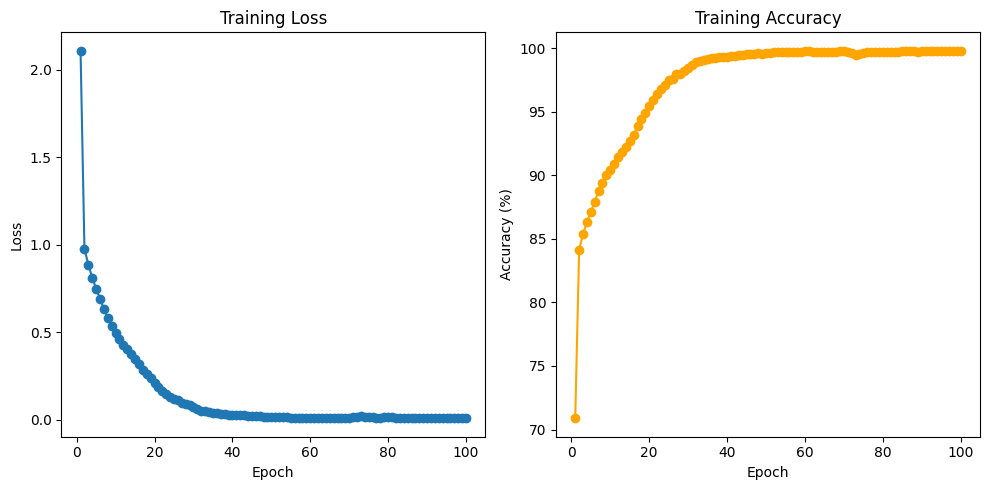

In [24]:
model = trainer(model, criterion, optimizer, num_epochs, pad)
torch.save(model.state_dict(), 'trained_model.pth')

In [25]:
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

Transformer(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): 

# Generating Caption & Visualizing Attention

A man in sunglasses throwing a frisbee outside.
tensor([  1,  16,  58,  51, 520, 659,  16, 205, 365,  12,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0])


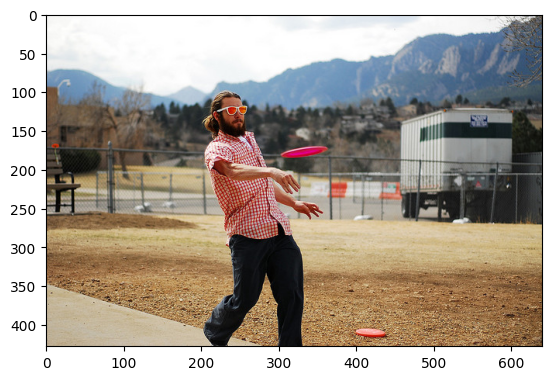

In [26]:
idx = random.choice(range(1000))

image = torch.FloatTensor(coco[idx][0]).to(device)
print(train_captions[idx])
print(targets[idx])
plt.imshow(Image.open(img_name_vector[idx]))

In [27]:
start = torch.tensor([start], dtype=dtype).to(device)
pad = torch.tensor([pad], dtype=dtype).to(device)
model = model.to(device)
with torch.no_grad():
  sample , att1, att2 = model.generate(image.unsqueeze(0), start_id=start, sample_size=max_len, pad = pad)

In [28]:
print(att1.shape) # [1, 4, 59, 196] : [batch_size, num_head, caption_len, num_patch]

attention = att1.squeeze(0).cpu().detach() # [1, 4, 59, 196] -> [4, 59, 196]

attention = attention.transpose(0, 1) # [4, 59, 196] -> [59, 4, 196]

print(attention.shape)

# 224 * 224 이미지를 16 * 16 패치로 분할하였으므로 패치 개수는 196 즉, 14 * 14. 
attentionMap = attention.reshape(-1, nhead, 14, 14) # [59, 4, 196] -> [59, 4, 14, 14]

# attention map 의 값이 너무 작아서 scaling
attentionMap = attentionMap * 50

print(attentionMap.shape)

torch.Size([1, 4, 59, 196])
torch.Size([59, 4, 196])
torch.Size([59, 4, 14, 14])


In [29]:
GN = [] # generated caption

for idx in sample.squeeze():
  if vocab.idx2word[idx.item()] == '<pad>':
    break
  GN.append(vocab.idx2word[idx.item()])
  print(vocab.idx2word[idx.item()], end=' ')

<start> smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling smiling 

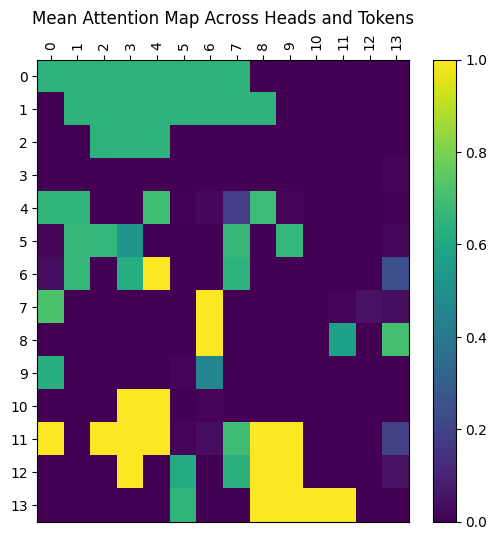

In [30]:
attention = attentionMap.mean(0).mean(0).cpu().detach().numpy() 

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

c = ax.pcolor(attention, cmap='viridis', vmin=0.0, vmax=1.0)

ax.patch.set_facecolor('black')

ax.set_yticks(np.arange(attention.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(attention.shape[1]) + 0.5, minor=False)

ax.invert_yaxis()
ax.xaxis.tick_top()  

seq_len = attention.shape[0]
ax.set_xticklabels(range(seq_len), minor=False, rotation=90)
ax.set_yticklabels(range(seq_len), minor=False)

fig.colorbar(c, ax=ax)

plt.title("Mean Attention Map Across Heads and Tokens")
plt.show()